# Guerra Mundial RS

## Imports
We start importing the required libraries

In [18]:
import numpy as np
import pandas as pd
import shapefile as shp
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import seaborn as sns
from tqdm import tqdm
from math import radians, cos, sin, asin, sqrt
import os
import json

And initializing the visualization set

In [2]:
sns.set(style='whitegrid', palette='pastel', color_codes=True)
sns.mpl.rc('figure', figsize=(10,6))
%matplotlib inline

## Shapefile structure

We will use a variable to configure the shapefile path, making sure you have the files in your local folder

In [3]:
shp_path = "./Municipio.shp"
sf = shp.Reader(shp_path)

This is a record example structure

In [4]:
sf.records()[231]

Record #231: ['Carlos Barbosa', '4304804', 1959, 'Carlos Barbosa', 'Sim']

## Helper functions

We will use a function to convert a shapefile to a Pandas DF object

In [48]:
def read_shapefile(sf):
    """
    Read a shapefile into a Pandas dataframe with a 'coords' 
    column holding the geometry information. This uses the pyshp
    package
    """
    fields = [x[0] for x in sf.fields][1:]
    records = sf.records()
    shps = [s.points for s in sf.shapes()]
    df = pd.DataFrame(columns=fields, data=records)
    df = df.assign(coords=shps)
    df = df.assign(owner=df.nome)
    df = df.assign(centre=[get_city_centre(df, city_name) for city_name in df['nome']])
    df = df.assign(color=[np.random.rand(3,) / 2 + 0.5 for city_name in df['nome']])
    return df

We have some function to compute data for each city, such as:

* their XY coordinates
* their center
* the distance between two points (two city centres)
* the distance from a city to all other cities in a list

In [6]:
def get_city_coordinates(df, city_name):
    """
    From a city_name, return its XY coordinates
    """
    # Fetch the shape coordinates
    coords = df[df.nome == city_name].coords.to_numpy()[0]
    x_lon = [point[0] for point in coords]
    y_lat = [point[1] for point in coords]
    
    return x_lon, y_lat

In [7]:
def get_city_centre(df, city_name):
    """
    From a city_name, return its center coordinates
    """
    
    # Fetch the shape information
    return np.mean(get_city_coordinates(df, city_name), 1)    

In [8]:
def haversine_distance(x0, y0, x1, y1):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    
    # Convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [x0, y0, x1, y1])

    # Haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers
    
    return c * r

In [9]:
def distance_to_other_cities(df, city):
    """
    Returns the Haversine distance for each city
    in relation to a given city, sorted by distance
    """
    city_centre = df[df.nome == city].centre.to_numpy()[0]
    distance = [(haversine_distance(*city_centre, *df[df.nome ==
                                                      other_city].centre.to_numpy()[0]), other_city,) for other_city in df.nome]
    
    return sorted(distance, key=lambda x: x[0])

We also use a function to plot a single shape

In [10]:
def plot_city(df, city_name, color='w', print_text=False, **kwargs):
    """ Plots a single shape """
      
    # Fetch and plot the shape
    x_lon, y_lat = get_city_coordinates(df, city_name)
    plt.fill(x_lon, y_lat, facecolor=color) 
    
    # Configure the text plotting
    if print_text:
        x_center, y_center = get_city_centre(df, city_name)
        plt.text(x_center, y_center, city_name, va='center', ha='center', **kwargs)

And a function to plot a map, and cities, by color

In [46]:
def plot_map_fill(sf, df, 
                      x_lim = None, 
                      y_lim = None, 
                      figsize = (16,13),
                      **kwargs):
    '''
    Plot map with lim coordinates, and the cities asked with their correspondent color
    '''
    
    # Configure the plot
    fig, ax = plt.subplots(figsize = figsize)
    
    # Plot all the cities in the map
    for shape in sf.shapeRecords():
        x = [point[0] for point in shape.shape.points[:]]
        y = [point[1] for point in shape.shape.points[:]]
        ax.plot(x, y, 'w', linewidth=0.06)
    
    # Plot the cities
    for owner_name in df.owner.unique():
        owner = df[df['nome'] == owner_name].iloc[0]
        owned_by = df[df['owner'] == owner_name]
        for index, row in owned_by.iterrows():            
            plot_city(df, row.nome, owner.color, **kwargs)
        
        x_center, y_center = np.mean([get_city_centre(df, owned_by_name) for owned_by_name in owned_by.nome], 0)
        txt = plt.text(x_center, y_center, owner_name, va='center', ha='center', **kwargs)
        txt.set_path_effects([PathEffects.withStroke(linewidth=4, foreground='w')])
    
    # Configure the map size
    if (x_lim != None) and (y_lim != None):     
        plt.xlim(x_lim)
        plt.ylim(y_lim)
    
    # plt.axes().set_aspect('scaled')

# Experiments

Here we have some space to test some stuff

In [12]:
df = read_shapefile(sf)
df

,nome,geocodigo,anoDeRefer,nomeAbrev,d_geometri,coords,owner,centre,color
0,Quaraí,4315305,1875,Quaraí,Sim,"[(-56.04483493099997, -30.049016369999947), (-...",Quaraí,"[-56.139744860368275, -30.277528926007495]","[0.31961677725158366, 0.11221359607074222, 0.2..."
1,Tuparendi,4322301,1959,Tuparendi,Sim,"[(-54.582405377999976, -27.589248864999945), (...",Tuparendi,"[-54.559122271563005, -27.686690801921934]","[0.7440530331806048, 0.034991670944519604, 0.5..."
2,Turuçu,4322327,1995,Turuçu,Sim,"[(-52.20587021299997, -31.376959297999974), (-...",Turuçu,"[-52.11795457770213, -31.553730516174838]","[0.5734754356751368, 0.23504413656936862, 0.92..."
3,Bom Jesus,4302303,1913,Bom Jesus,Sim,"[(-50.71894901999997, -28.26114945699993), (-5...",Bom Jesus,"[-50.517930127111434, -28.50676956560769]","[0.5298670472992725, 0.8156812487174837, 0.563..."
4,Capão da Canoa,4304630,1982,Capão da Canoa,Sim,"[(-49.991792000999965, -29.606068998999945), (...",Capão da Canoa,"[-50.01279731865671, -29.644739373324153]","[0.5900546193642151, 0.5293723826734343, 0.763..."
5,Chuvisca,4305447,1995,Chuvisca,Sim,"[(-51.97663894899995, -30.660451812999952), (-...",Chuvisca,"[-52.012816626406, -30.78654048226133]","[0.3637820386927424, 0.47669437900129186, 0.27..."
6,Coronel Bicaco,4305900,1963,Cel. Bicaco,Sim,"[(-53.73567824199995, -27.660281673999975), (-...",Coronel Bicaco,"[-53.67358112523211, -27.843061892520428]","[0.1490676704754974, 0.6788418185133537, 0.082..."
7,Forquetinha,4308433,1996,Forquetinha,Sim,"[(-52.16307645099994, -29.329481055999963), (-...",Forquetinha,"[-52.1489944520316, -29.393849310823484]","[0.4983014280712562, 0.41858568639568683, 0.72..."
8,Fortaleza dos Valos,4308458,1982,Fortaleza dos Valos,Sim,"[(-53.284034314999985, -28.724480907999975), (...",Fortaleza dos Valos,"[-53.33885093078541, -28.8895100584575]","[0.8902162157435889, 0.20307017952231265, 0.71..."
9,Frederico Westphalen,4308508,1954,Frederico Westphalen,Sim,"[(-53.32702393799997, -27.221732372999952), (-...",Frederico Westphalen,"[-53.28712898107338, -27.33042438073956]","[0.7500787029106096, 0.4883821207643897, 0.957..."


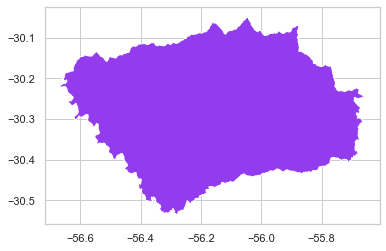

In [13]:
plot_city(df, 'Quaraí', df.iloc[2].color)

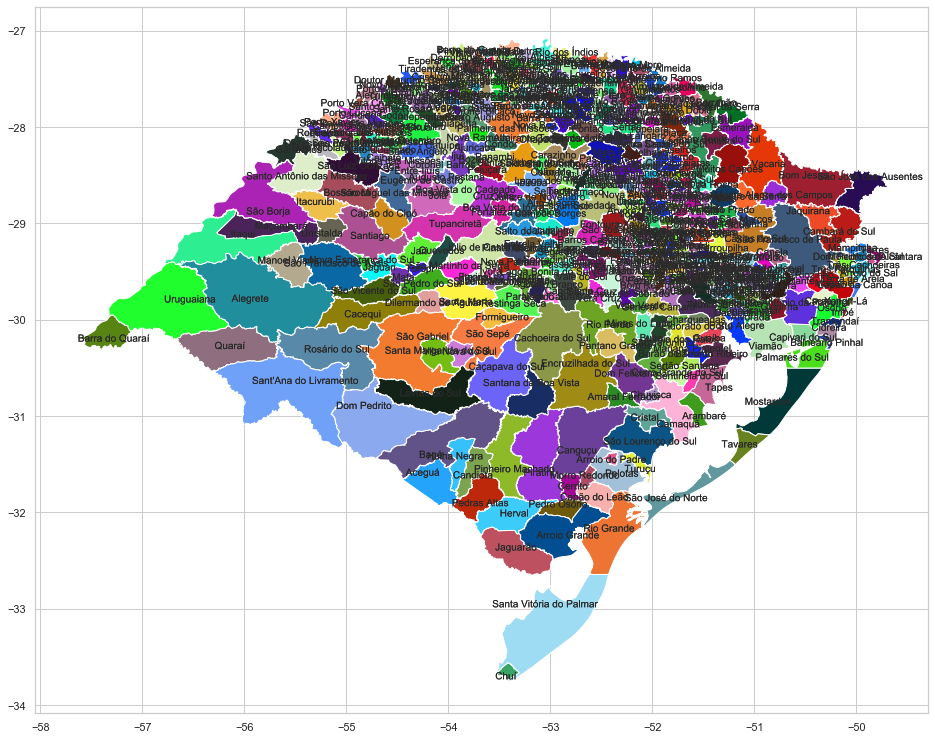

In [16]:
df = df.assign(color=[np.random.rand(3,) for city_name in df['nome']])
plot_map_fill(sf, df, fontsize=7)

# Guerra testing

Here we try some testing seeing who will win this war

In [19]:
# Precompute the distances
if os.path.isfile('./distances.json'):
    print("Fetching distances from cached file")
    with open('./distances.json', 'r') as f:
        DISTANCES = json.load(f)
else:
    print("Computing distances")
    with tqdm(df['nome']) as t:
        for city_name in t:
            t.set_description(city_name)
            DISTANCES[city_name] = distance_to_other_cities(df, city_name)

    # Write the distances to a file
    print("Writing distances to cache file")
    with open('distances.json', 'w') as f:
        json.dump(DISTANCES, f)

Computing distances


Silveira Martins: 100%|██████████████████████████████████████████████████████████████| 497/497 [04:57<00:00,  1.82it/s]


Writing distances to cache file


In [41]:
# Re-fetch the owner
df = df.assign(owner=df.nome)
df = df.assign(color=[np.random.rand(3,) / 2 + 0.5 for city_name in df['nome']])

In [21]:
def run(*, times=1):
    for i in range(times):
        if len(df.owner.unique()) > 1:
            # Get the reference to the attacking city
            attack_city = df.sample()

            # Get the reference to the attacking city owner
            attack_city_owner = df[df.nome == attack_city.owner.to_numpy()[0]]

            # Get the attacking city name
            attack_name = attack_city.nome.to_numpy()[0]

            # Get the distance to the other cities
            distance_to_cities = DISTANCES[attack_name]

            # Get the names from all cities under the same owner
            owned_by_same = df[df.owner == attack_city_owner.nome.to_numpy()[0]].nome.to_numpy()

            # Get the name of the first city, in distance, which is not owned by the same guy
            defend_name = next(city[1] for city in distance_to_cities if city[1] not in owned_by_same and city[1])

            # Get its correspondent reference
            defend_city = df[df.nome == defend_name]

            # Get its owner
            defend_city_owner = df[df.nome == defend_city.owner.to_numpy()[0]]

            # Print information
            print("{} conquers {} from {} through {}".format(attack_city_owner.nome.to_numpy()[0], defend_name, defend_city_owner.nome.to_numpy()[0], attack_name))

            # Update the city owner
            df.loc[df['nome'] == defend_name, ['owner']] = attack_city_owner.nome.to_numpy()[0]   

    

In [44]:
run(times=1500)

Pantano Grande conquers Rio Pardo from Rio Pardo through Pantano Grande
São Jorge conquers Vanini from Vanini through São Jorge
Coqueiros do Sul conquers Almirante Tamandaré do Sul from Almirante Tamandaré do Sul through Coqueiros do Sul
Victor Graeff conquers Tio Hugo from Tio Hugo through Victor Graeff
Não-Me-Toque conquers Lagoa dos Três Cantos from Lagoa dos Três Cantos through Não-Me-Toque
Arroio do Meio conquers Lajeado from Lajeado through Arroio do Meio
Pejuçara conquers Bozano from Bozano through Pejuçara
Boa Vista das Missões conquers Jaboticaba from Jaboticaba through Boa Vista das Missões
Araricá conquers Parobé from Parobé through Araricá
Caiçara conquers Vicente Dutra from Vicente Dutra through Caiçara
Capão do Leão conquers Cerrito from Cerrito through Capão do Leão
Fortaleza dos Valos conquers Boa Vista do Incra from Boa Vista do Incra through Fortaleza dos Valos
Ivoti conquers Presidente Lucena from Presidente Lucena through Ivoti
Barracão conquers Pinhal da Serra from

Charqueadas conquers Eldorado do Sul from Guaíba through Charqueadas
Ciríaco conquers Muliterno from Muliterno through Ciríaco
Caiçara conquers Frederico Westphalen from Frederico Westphalen through Caiçara
Tenente Portela conquers Miraguaí from Três Passos through Tenente Portela
Portão conquers Estância Velha from Estância Velha through Portão
Cerro Grande conquers Sagrada Família from Sagrada Família through Cerro Grande
Entre Rios do Sul conquers São Valentim from São Valentim through Benjamin Constant do Sul
Nova Boa Vista conquers Barra Funda from Barra Funda through Nova Boa Vista
Nicolau Vergueiro conquers Ibirapuitã from Ibirapuitã through Nicolau Vergueiro
Passo Fundo conquers Marau from Marau through Passo Fundo
Rodeio Bonito conquers Liberato Salzano from Liberato Salzano through Rodeio Bonito
Mariano Moro conquers Aratiba from Aratiba through Mariano Moro
Gramado Xavier conquers Lagoão from Lagoão through Gramado Xavier
Dom Pedrito conquers Lavras do Sul from Lavras do Sul

Anta Gorda conquers Guaporé from União da Serra through Anta Gorda
Engenho Velho conquers Trindade do Sul from Trindade do Sul through Três Palmeiras
Rondinha conquers Sarandi from Sarandi through Rondinha
Lajeado do Bugre conquers Sagrada Família from São José das Missões through Lajeado do Bugre
Esperança do Sul conquers Derrubadas from Derrubadas through Esperança do Sul
Candelária conquers Novo Cabrais from Novo Cabrais through Candelária
Severiano de Almeida conquers Mariano Moro from Mariano Moro through Severiano de Almeida
Três de Maio conquers Boa Vista do Buricá from Boa Vista do Buricá through São José do Inhacorá
Novo Cabrais conquers Novo Cabrais from Candelária through Paraíso do Sul
Barão de Cotegipe conquers São Valentim from Entre Rios do Sul through Barão de Cotegipe
Dezesseis de Novembro conquers Roque Gonzales from Roque Gonzales through Dezesseis de Novembro
Tupanci do Sul conquers Santo Expedito do Sul from Sananduva through Tupanci do Sul
Erval Grande conquers It

Glorinha conquers Santo Antônio da Patrulha from Santo Antônio da Patrulha through Glorinha
Linha Nova conquers Picada Café from Picada Café through Linha Nova
Barra do Ribeiro conquers Barão do Triunfo from Barão do Triunfo through Arroio dos Ratos
Itati conquers Terra de Areia from Terra de Areia through Três Forquilhas
Passo do Sobrado conquers Vale Verde from Vale Verde through Passo do Sobrado
São Martinho da Serra conquers Itaara from Santa Maria through São Martinho da Serra
Anta Gorda conquers Vista Alegre do Prata from União da Serra through Guaporé
Boqueirão do Leão conquers Pouso Novo from Progresso through Progresso
Vitória das Missões conquers Mato Queimado from Sete de Setembro through Vitória das Missões
São José dos Ausentes conquers Bom Jesus from Bom Jesus through São José dos Ausentes
Canguçu conquers Morro Redondo from Capão do Leão through Canguçu
Ibarama conquers Segredo from Gramado Xavier through Sobradinho
Cambará do Sul conquers Morrinhos do Sul from Três Cach

Ibarama conquers Lagoa Bonita do Sul from Lagoa Bonita do Sul through Ibarama
Maquiné conquers Capão da Canoa from Xangri-Lá through Terra de Areia
Santa Vitória do Palmar conquers Arroio Grande from Arroio Grande through Santa Vitória do Palmar
Campo Bom conquers Campo Bom from Araricá through Novo Hamburgo
Pinto Bandeira conquers Bento Gonçalves from Bento Gonçalves through Pinto Bandeira
Gramado Xavier conquers Passa Sete from Passa Sete through Sinimbu
Capão Bonito do Sul conquers Lagoa Vermelha from Lagoa Vermelha through Capão Bonito do Sul
Glorinha conquers Taquara from Araricá through Santo Antônio da Patrulha
Engenho Velho conquers Cerro Grande from Cerro Grande through Três Palmeiras
Nova Bréscia conquers Encantado from Encantado through Capitão
Mato Leitão conquers Canudos do Vale from Canudos do Vale through Forquetinha
Faxinalzinho conquers Rio dos Índios from Rio dos Índios through Nonoai
Jóia conquers Boa Vista do Cadeado from Boa Vista do Cadeado through Augusto Pestana

Pantano Grande conquers Pantano Grande from Amaral Ferrador through Rio Pardo
Tabaí conquers Bom Retiro do Sul from Cruzeiro do Sul through Fazenda Vilanova
Capão do Cipó conquers Jaguari from Nova Esperança do Sul through Nova Esperança do Sul
São Francisco de Paula conquers Caxias do Sul from Caxias do Sul through São Francisco de Paula
Caiçara conquers Pinheirinho do Vale from Vista Gaúcha through Caiçara
Santa Margarida do Sul conquers Santa Maria from Mata through São Sepé
Caiçara conquers Vista Gaúcha from Vista Gaúcha through Vicente Dutra
Carazinho conquers Chapada from Chapada through Saldanha Marinho
Pinheiro Machado conquers Herval from Santa Vitória do Palmar through Pedras Altas
Viamão conquers Balneário Pinhal from Balneário Pinhal through Palmares do Sul
Erebango conquers Erechim from Erechim through Paulo Bento
São Francisco de Assis conquers Nova Esperança do Sul from Capão do Cipó through São Francisco de Assis
Riozinho conquers Riozinho from Maquiné through Rolante
A

Gramado Xavier conquers Cerro Branco from Ibarama through Vale do Sol
Entre Rios do Sul conquers São Valentim from Barão de Cotegipe through Cruzaltense
Barracão conquers Cacique Doble from Sananduva through São José do Ouro
Horizontina conquers Novo Machado from Alecrim through Doutor Maurício Cardoso
Serafina Corrêa conquers Casca from Gentil through Serafina Corrêa
Mato Leitão conquers Marques de Souza from Travesseiro through Canudos do Vale
Pinheiro Machado conquers Pedro Osório from Santa Vitória do Palmar through Pinheiro Machado
Amaral Ferrador conquers Camaquã from Camaquã through São Lourenço do Sul
Ibarama conquers Nova Palma from Pinhal Grande through Ibarama
Passo Fundo conquers Água Santa from Mato Castelhano through Mato Castelhano
Mato Leitão conquers Mato Leitão from Cruzeiro do Sul through Santa Clara do Sul
Três Arroios conquers Severiano de Almeida from Severiano de Almeida through Três Arroios
Gentil conquers Vila Maria from Montauri through Gentil
Barra do Ribeiro

Pinheiro Machado conquers Bagé from Bagé through Candiota
Barra do Rio Azul conquers Erval Grande from Faxinalzinho through Itatiba do Sul
Giruá conquers Ubiretama from Dezesseis de Novembro through Senador Salgado Filho
Xangri-Lá conquers Maquiné from Maquiné through Osório
Catuípe conquers Coronel Barros from Jóia through Ijuí
Engenho Velho conquers Rodeio Bonito from Caiçara through Liberato Salzano
Tupandi conquers São Sebastião do Caí from Portão through Harmonia
Boa Vista das Missões conquers Novo Xingu from São José das Missões through Sagrada Família
Passo Fundo conquers Vila Lângaro from Água Santa through Água Santa
Erebango conquers Jacutinga from Campinas do Sul through Erebango
Tupandi conquers São José do Hortêncio from Portão through São Sebastião do Caí
Boa Vista das Missões conquers Cerro Grande from Engenho Velho through Jaboticaba
Amaral Ferrador conquers Sentinela do Sul from Barra do Ribeiro through Chuvisca
Caiçara conquers Rodeio Bonito from Engenho Velho through

Pinto Bandeira conquers Veranópolis from Veranópolis through Pinto Bandeira
Erebango conquers Cruzaltense from Entre Rios do Sul through Ponte Preta
Santo Ângelo conquers Vitória das Missões from Vitória das Missões through Santo Ângelo
Arroio Grande conquers Arroio Grande from Santa Vitória do Palmar through Rio Grande
Carazinho conquers Boa Vista do Incra from Fortaleza dos Valos through Quinze de Novembro
Glorinha conquers Sapiranga from Santa Maria do Herval through Araricá
Carazinho conquers Salto do Jacuí from Fortaleza dos Valos through Fortaleza dos Valos
Esmeralda conquers Lagoa Vermelha from Capão Bonito do Sul through Capão Bonito do Sul
Erebango conquers Vila Lângaro from Passo Fundo through Coxilha
Maçambará conquers Itaqui from Quaraí through São Borja
Carazinho conquers Cruz Alta from Jóia through Fortaleza dos Valos
Três de Maio conquers Nova Candelária from Crissiumal through Boa Vista do Buricá
Carazinho conquers Boa Vista do Cadeado from Jóia through Boa Vista do Inc

Veranópolis conquers São Valentim do Sul from Santa Tereza through Cotiporã
Sananduva conquers Charrua from Erebango through Sananduva
Caiçara conquers Liberato Salzano from Engenho Velho through Rodeio Bonito
Crissiumal conquers Sede Nova from Três de Maio through Humaitá
Caiçara conquers Palmitinho from Seberi through Vista Alegre
Anta Gorda conquers Coqueiro Baixo from Gramado Xavier through Relvado
Portão conquers Feliz from Tupandi through São José do Hortêncio
Engenho Velho conquers Liberato Salzano from Caiçara through Novo Tiradentes
Seberi conquers Dois Irmãos das Missões from Dois Irmãos das Missões through Redentora
Bagé conquers Candiota from Pinheiro Machado through Hulha Negra
Gramado Xavier conquers Jacuizinho from Carazinho through Barros Cassal
Boa Vista das Missões conquers Dois Irmãos das Missões from Seberi through Boa Vista das Missões
Barra do Ribeiro conquers Vale Verde from Passo do Sobrado through Minas do Leão
Esteio conquers São Leopoldo from Portão through S

Gramado Xavier conquers Candelária from Candelária through Herveiras
Sete de Setembro conquers Salvador das Missões from Porto Vera Cruz through Cerro Largo
Capão do Cipó conquers Jóia from Mata through Eugênio de Castro
Caiçara conquers Palmitinho from Seberi through Caiçara
Porto Vera Cruz conquers Salvador das Missões from Sete de Setembro through São Paulo das Missões
Barra do Ribeiro conquers Vale Verde from Passo do Sobrado through General Câmara
Barra do Ribeiro conquers Esteio from Esteio through Nova Santa Rita
Maçambará conquers Rosário do Sul from Cacequi through Alegrete
Bagé conquers Dom Pedrito from Santa Margarida do Sul through Aceguá
Sete de Setembro conquers São Pedro do Butiá from Dezesseis de Novembro through Rolador
Faxinalzinho conquers Itatiba do Sul from Barra do Rio Azul through Erval Grande
Erebango conquers Áurea from Gaurama through Floriano Peixoto
Boa Vista das Missões conquers Pinhal from Caiçara through Boa Vista das Missões
Sananduva conquers Paim Filho

Monte Alegre dos Campos conquers Campestre da Serra from Muitos Capões through Monte Alegre dos Campos
Três de Maio conquers Sede Nova from Crissiumal through São José do Inhacorá
Anta Gorda conquers Nova Bréscia from Nova Bréscia through Coqueiro Baixo
Carazinho conquers Ibarama from Ibarama through Pinhal Grande
Maçambará conquers São Nicolau from Garruchos through Itaqui
Gramado Xavier conquers Canudos do Vale from Mato Leitão through Boqueirão do Leão
Carazinho conquers Pontão from Erebango through Coqueiros do Sul
Carazinho conquers Coronel Barros from Catuípe through Pejuçara
Três de Maio conquers Humaitá from Crissiumal through Sede Nova
Três de Maio conquers São Valério do Sul from São Valério do Sul through São Martinho
Gramado Xavier conquers Segredo from Carazinho through Herveiras
Tupandi conquers Salvador do Sul from Poço das Antas through São Pedro da Serra
Três de Maio conquers Crissiumal from Horizontina through Humaitá
Sananduva conquers Viadutos from Marcelino Ramos t

Xangri-Lá conquers Capivari do Sul from Camaquã through Tramandaí
Boa Vista das Missões conquers Sagrada Família from Nova Boa Vista through Cerro Grande
Faxinalzinho conquers Severiano de Almeida from Erebango through Três Arroios
Chuí conquers Santa Vitória do Palmar from Santa Vitória do Palmar through Chuí
Porto Vera Cruz conquers Santo Cristo from Alecrim through Porto Vera Cruz
Gentil conquers Casca from Serafina Corrêa through Santo Antônio do Palma
Carazinho conquers Arroio do Tigre from Gramado Xavier through Salto do Jacuí
Gramado Xavier conquers Tunas from Carazinho through Barros Cassal
Boa Vista das Missões conquers Novo Xingu from Nova Boa Vista through Sagrada Família
Tupandi conquers Vale Real from São Francisco de Paula through Farroupilha
Montauri conquers Vila Maria from Gentil through Montauri
Faxinalzinho conquers Benjamin Constant do Sul from Erebango through Erval Grande
Colinas conquers Westfalia from Westfalia through Teutônia
Cambará do Sul conquers Terra de A

Erebango conquers Três Arroios from Faxinalzinho through Gaurama
Carazinho conquers Ronda Alta from Erebango through Carazinho
Montauri conquers Relvado from Anta Gorda through Ilópolis
Tabaí conquers General Câmara from Barra do Ribeiro through Taquari
Arroio Grande conquers Pedro Osório from Pinheiro Machado through Arroio Grande
Carazinho conquers São José das Missões from Nova Boa Vista through Chapada
Vacaria conquers Jaquirana from São Francisco de Paula through Bom Jesus
Cambará do Sul conquers Itati from Xangri-Lá through Mampituba
Porto Vera Cruz conquers Campina das Missões from Alecrim through São Paulo das Missões
Santa Margarida do Sul conquers Paraíso do Sul from Candelária through Cachoeira do Sul
Carazinho conquers Novo Xingu from Boa Vista das Missões through São José das Missões
Carazinho conquers Santo Augusto from Três de Maio through Panambi
Carazinho conquers Coxilha from Erebango through Colorado
Anta Gorda conquers Relvado from Montauri through Coqueiro Baixo
Sa

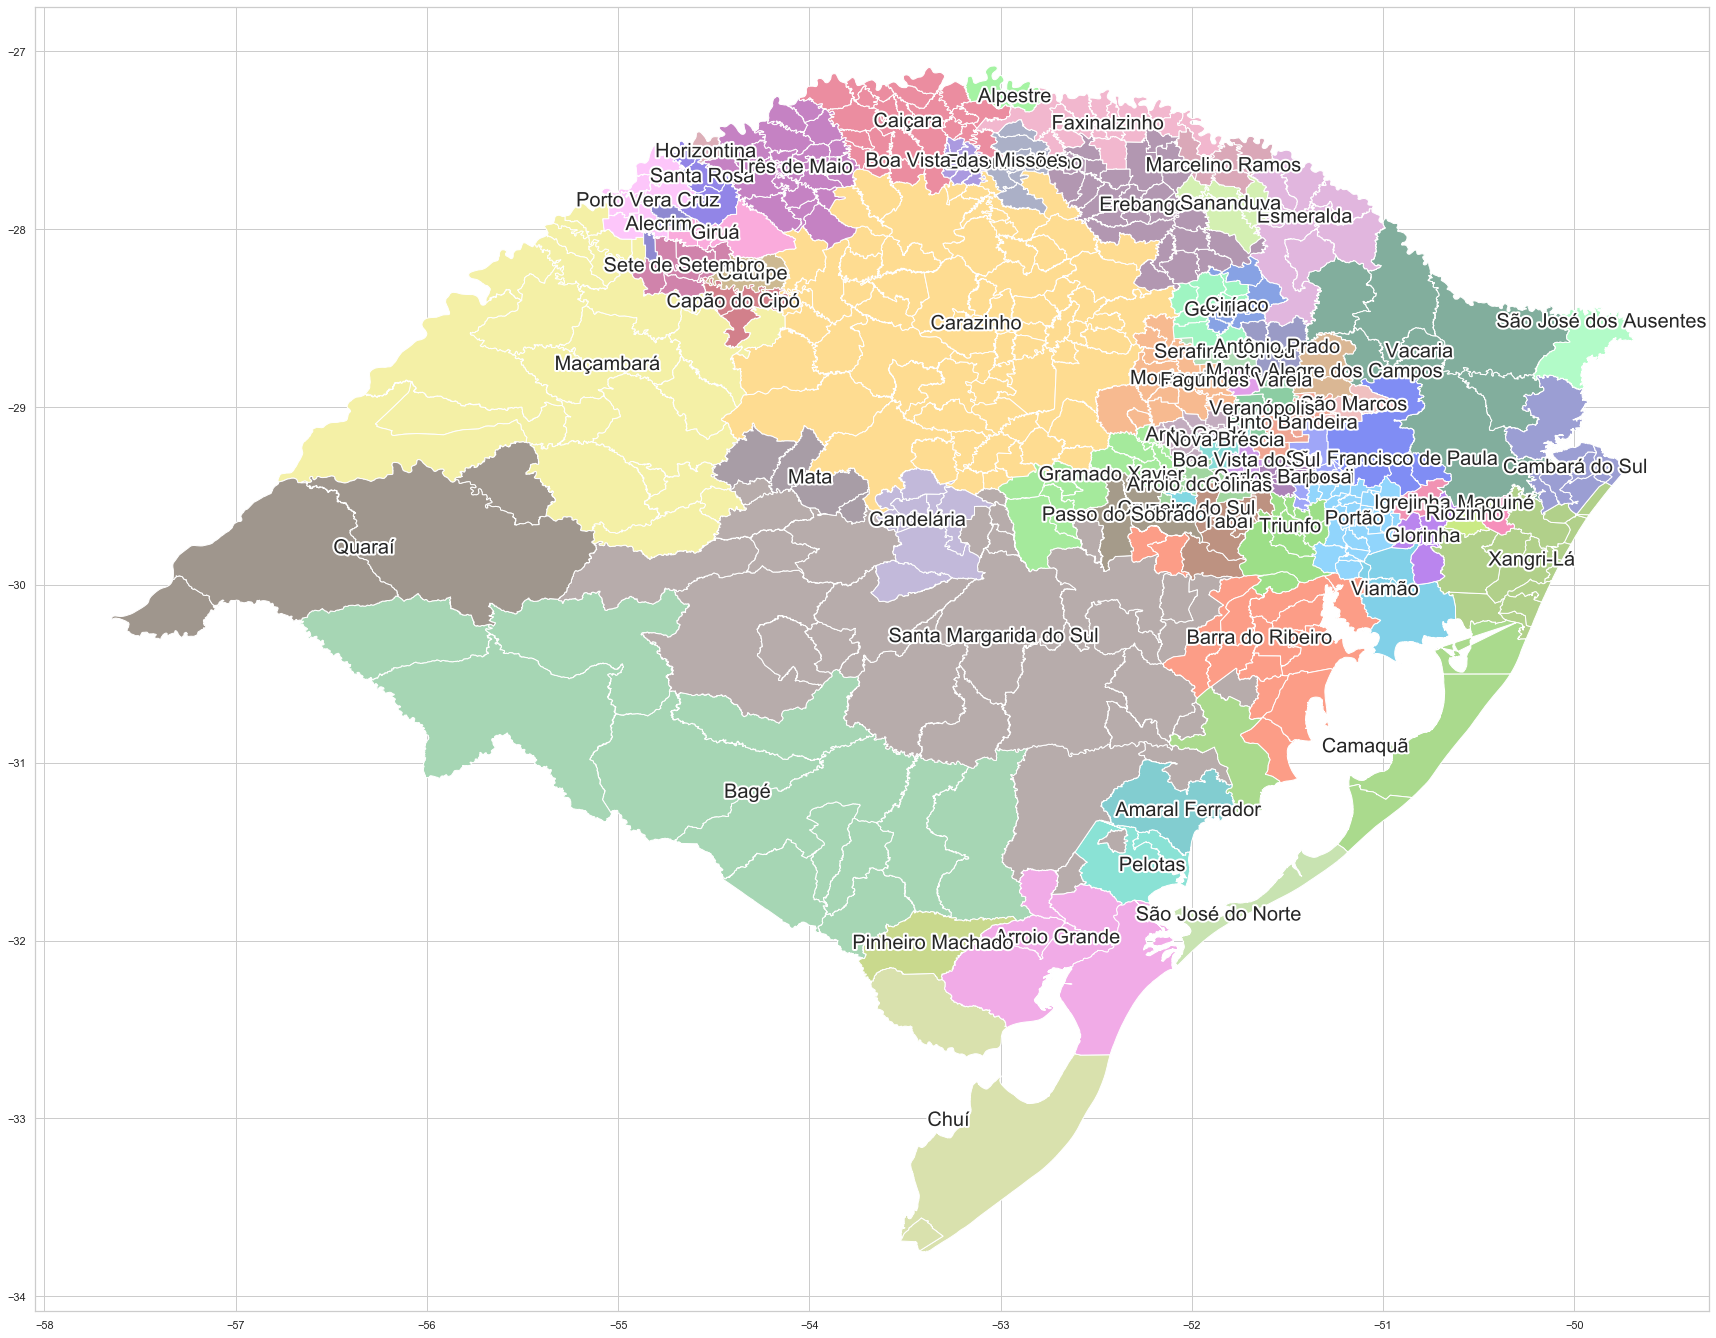

In [47]:
plot_map_fill(sf, df, fontsize=20, figsize=(30,24))